## Final Project Team Cedar, Fall 2022

### CoverMyMeds

### Goal 2: Predicting patient co-pay

For our second goal we are using a regression model to predict how much patients will have to pay for their prescription medication. 

First import necessary packages:

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

Next import the dataset, split the drug column as before and subset to only the accepted transactions. As we saw during our data exploration, co-pay is always $0 for rejected medications, so these transactions are not informative for predicting co-pays. 

In [3]:
rx = pd.read_csv("./data/pharmacy_tx.csv")
rx[["drug_type","drug_name"]] = rx['drug'].str.split(" ",expand=True)
rx_accepted = rx[rx["rejected"] == False]

In [23]:
rx_accepted['patient_pay'].describe()

count    1.282338e+07
mean     2.609971e+01
std      4.051418e+01
min      3.400000e+00
25%      1.045000e+01
50%      1.393000e+01
75%      1.975000e+01
max      5.579300e+02
Name: patient_pay, dtype: float64

Make a test/train split of the overall dataset, retaining a test dataset for final performance testing of the model.

In [4]:
## Make the train test split for accepted transactions only
acc_train, acc_test = train_test_split(rx_accepted.copy(), 
                                            shuffle=True,
                                            random_state=614,
                                            test_size=.2)

In [5]:
acc_train.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,drug_type,drug_name
10120050,2022-09-29,Pharmacy #26,G99.93,branded hozirol,664344,T17LNK,Z01MLD4I,False,17.44,branded,hozirol
687578,2022-01-21,Pharmacy #31,G51.87,branded prazinib,725700,NaN,DYGBI610ZY,False,11.22,branded,prazinib
9300050,2022-09-09,Pharmacy #28,Q85.91,branded plazamiglutic,322463,T52GV,EVD4X5,False,8.21,branded,plazamiglutic
631063,2022-01-20,Pharmacy #4,H36.57,branded antimab,571569,KB38N,6BYJBW,False,23.26,branded,antimab
8642802,2022-08-23,Pharmacy #54,K32.86,branded tanoclolol,664344,BIZF,QK6BI1N61,False,11.62,branded,tanoclolol


Based on our data exploration, we know that not all variables are going to be informative, so we can drop those here and only keep informative variables:

In [6]:
Xacc = acc_train.drop(["tx_date", "drug", "patient_pay", "pharmacy", "rejected"], axis = 1)
yacc = acc_train["patient_pay"]

In [7]:
Xacc.head()

,diagnosis,bin,pcn,group,drug_type,drug_name
10120050,G99.93,664344,T17LNK,Z01MLD4I,branded,hozirol
687578,G51.87,725700,NaN,DYGBI610ZY,branded,prazinib
9300050,Q85.91,322463,T52GV,EVD4X5,branded,plazamiglutic
631063,H36.57,571569,KB38N,6BYJBW,branded,antimab
8642802,K32.86,664344,BIZF,QK6BI1N61,branded,tanoclolol


For xgboost to work, we need to make sure our categorical variables are saved as such and not as objects:

In [8]:
Xacc["diagnosis"] = Xacc["diagnosis"].astype("category")
Xacc["drug_type"] = Xacc["drug_type"].astype("category")
Xacc["drug_name"] = Xacc["drug_name"].astype("category")
Xacc["bin"] = Xacc["bin"].astype("category")
Xacc["pcn"] = Xacc["pcn"].astype("category")
Xacc["group"] = Xacc["group"].astype("category")

#### Cross validation

Make another train/test split of the training data:

In [9]:
Xacc_train, Xacc_test, yacc_train, yacc_test = train_test_split(
                                    Xacc, yacc, random_state=22, test_size=0.2)

In [10]:
## Make the KFold object
kfold = KFold(n_splits=5,
                 shuffle=True,
                 random_state=431)

In [11]:
mses = np.zeros((2, 5))

i = 0

for train_index, test_index in kfold.split(Xacc_train, yacc_train):
    Xacc_tt = Xacc_train.iloc[train_index]
    Xacc_ho = Xacc_train.iloc[test_index]
    
    yacc_tt = yacc_train.iloc[train_index]
    yacc_ho = yacc_train.iloc[test_index]
    
    ## baseline model
    pred_baseline = yacc_tt.mean()*np.ones(len(yacc_ho))
    
    ## SLR model
    reg_acc = xgboost.XGBRegressor(tree_method="hist", enable_categorical=True, max_cat_to_onehot=1)
    reg_acc.fit(Xacc_tt, yacc_tt, eval_set=[(Xacc_ho, yacc_ho), (Xacc_tt, yacc_tt)])
    pred = reg_acc.predict(Xacc_ho)
    
    ### record MSEs ###
    mses[0,i] = mse(yacc_ho, pred_baseline)
    mses[1,i] = mse(yacc_ho, pred)

    ## increase the counter
    i = i + 1

[0]	validation_0-rmse:34.12815	validation_1-rmse:34.10823
[1]	validation_0-rmse:24.64378	validation_1-rmse:24.63114
[2]	validation_0-rmse:18.15223	validation_1-rmse:18.13622
[3]	validation_0-rmse:13.77576	validation_1-rmse:13.76137
[4]	validation_0-rmse:10.89953	validation_1-rmse:10.88635
[5]	validation_0-rmse:8.97417	validation_1-rmse:8.96169
[6]	validation_0-rmse:7.52862	validation_1-rmse:7.51926
[7]	validation_0-rmse:6.73910	validation_1-rmse:6.73105
[8]	validation_0-rmse:6.19409	validation_1-rmse:6.18861
[9]	validation_0-rmse:5.82391	validation_1-rmse:5.82043
[10]	validation_0-rmse:5.63394	validation_1-rmse:5.62956
[11]	validation_0-rmse:5.37380	validation_1-rmse:5.37042
[12]	validation_0-rmse:5.08738	validation_1-rmse:5.08454
[13]	validation_0-rmse:4.88794	validation_1-rmse:4.88780
[14]	validation_0-rmse:4.73740	validation_1-rmse:4.73737
[15]	validation_0-rmse:4.64507	validation_1-rmse:4.64469
[16]	validation_0-rmse:4.52814	validation_1-rmse:4.52462
[17]	validation_0-rmse:4.43673	

[44]	validation_0-rmse:3.03335	validation_1-rmse:3.02758
[45]	validation_0-rmse:3.02064	validation_1-rmse:3.01484
[46]	validation_0-rmse:3.00778	validation_1-rmse:3.00233
[47]	validation_0-rmse:2.99504	validation_1-rmse:2.98923
[48]	validation_0-rmse:2.96390	validation_1-rmse:2.95736
[49]	validation_0-rmse:2.95056	validation_1-rmse:2.94382
[50]	validation_0-rmse:2.92883	validation_1-rmse:2.92199
[51]	validation_0-rmse:2.91665	validation_1-rmse:2.90964
[52]	validation_0-rmse:2.90707	validation_1-rmse:2.90003
[53]	validation_0-rmse:2.89562	validation_1-rmse:2.88875
[54]	validation_0-rmse:2.88679	validation_1-rmse:2.87942
[55]	validation_0-rmse:2.87877	validation_1-rmse:2.87142
[56]	validation_0-rmse:2.86940	validation_1-rmse:2.86202
[57]	validation_0-rmse:2.85836	validation_1-rmse:2.85077
[58]	validation_0-rmse:2.85072	validation_1-rmse:2.84294
[59]	validation_0-rmse:2.84549	validation_1-rmse:2.83783
[60]	validation_0-rmse:2.83315	validation_1-rmse:2.82615
[61]	validation_0-rmse:2.82589	

[88]	validation_0-rmse:2.65155	validation_1-rmse:2.66964
[89]	validation_0-rmse:2.64667	validation_1-rmse:2.66472
[90]	validation_0-rmse:2.64281	validation_1-rmse:2.66090
[91]	validation_0-rmse:2.64003	validation_1-rmse:2.65812
[92]	validation_0-rmse:2.63669	validation_1-rmse:2.65486
[93]	validation_0-rmse:2.63401	validation_1-rmse:2.65227
[94]	validation_0-rmse:2.63064	validation_1-rmse:2.64891
[95]	validation_0-rmse:2.62840	validation_1-rmse:2.64668
[96]	validation_0-rmse:2.62596	validation_1-rmse:2.64406
[97]	validation_0-rmse:2.62111	validation_1-rmse:2.63922
[98]	validation_0-rmse:2.61871	validation_1-rmse:2.63677
[99]	validation_0-rmse:2.61187	validation_1-rmse:2.62990
[0]	validation_0-rmse:34.11447	validation_1-rmse:34.10899
[1]	validation_0-rmse:24.63771	validation_1-rmse:24.63119
[2]	validation_0-rmse:18.13817	validation_1-rmse:18.13560
[3]	validation_0-rmse:13.76507	validation_1-rmse:13.76044
[4]	validation_0-rmse:10.91212	validation_1-rmse:10.90204
[5]	validation_0-rmse:9.02

[32]	validation_0-rmse:3.43173	validation_1-rmse:3.42087
[33]	validation_0-rmse:3.40599	validation_1-rmse:3.39590
[34]	validation_0-rmse:3.36789	validation_1-rmse:3.35790
[35]	validation_0-rmse:3.33853	validation_1-rmse:3.32791
[36]	validation_0-rmse:3.30148	validation_1-rmse:3.29068
[37]	validation_0-rmse:3.27488	validation_1-rmse:3.26403
[38]	validation_0-rmse:3.24760	validation_1-rmse:3.23664
[39]	validation_0-rmse:3.22313	validation_1-rmse:3.21267
[40]	validation_0-rmse:3.20243	validation_1-rmse:3.19178
[41]	validation_0-rmse:3.17209	validation_1-rmse:3.16150
[42]	validation_0-rmse:3.14917	validation_1-rmse:3.13842
[43]	validation_0-rmse:3.12571	validation_1-rmse:3.11454
[44]	validation_0-rmse:3.10451	validation_1-rmse:3.09408
[45]	validation_0-rmse:3.07335	validation_1-rmse:3.06279
[46]	validation_0-rmse:3.05872	validation_1-rmse:3.04813
[47]	validation_0-rmse:3.03789	validation_1-rmse:3.02723
[48]	validation_0-rmse:3.01964	validation_1-rmse:3.00903
[49]	validation_0-rmse:3.00685	

In [12]:
##### Print the results
print("The average cross-validation mse for the baseline model is",
                      np.round(np.mean(mses, axis=1)[0],4))
print("The average cross-validation mse for the xgboost regression model is",
                      np.round(np.mean(mses, axis=1)[1],4))

The average cross-validation mse for the baseline model is 1639.5535
The average cross-validation mse for the xgboost regression model is 6.9559


The mean squared error of the regression model is much lower than that of the baseline model, suggesting that the regression model is performing well. We will train the model on the full training dataset and save it: 

In [13]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
reg_acc = xgboost.XGBRegressor(tree_method="hist", enable_categorical=True, max_cat_to_onehot=1)
# fit the model
reg_acc.fit(Xacc_train, yacc_train, eval_set=[(Xacc_test, yacc_test), (Xacc_train, yacc_train)])
# Save the model
reg_acc.save_model("regression-model_pay.json")

[0]	validation_0-rmse:34.15527	validation_1-rmse:34.11041
[1]	validation_0-rmse:24.66910	validation_1-rmse:24.63213
[2]	validation_0-rmse:18.16734	validation_1-rmse:18.13693
[3]	validation_0-rmse:13.78243	validation_1-rmse:13.76247
[4]	validation_0-rmse:10.90279	validation_1-rmse:10.89037
[5]	validation_0-rmse:8.96452	validation_1-rmse:8.95534
[6]	validation_0-rmse:7.54340	validation_1-rmse:7.54142
[7]	validation_0-rmse:6.73176	validation_1-rmse:6.73096
[8]	validation_0-rmse:6.16681	validation_1-rmse:6.17132
[9]	validation_0-rmse:5.74314	validation_1-rmse:5.74300
[10]	validation_0-rmse:5.48164	validation_1-rmse:5.48349
[11]	validation_0-rmse:5.23838	validation_1-rmse:5.24157
[12]	validation_0-rmse:5.11101	validation_1-rmse:5.11418
[13]	validation_0-rmse:4.85790	validation_1-rmse:4.86153
[14]	validation_0-rmse:4.71080	validation_1-rmse:4.71258
[15]	validation_0-rmse:4.56564	validation_1-rmse:4.56676
[16]	validation_0-rmse:4.42590	validation_1-rmse:4.42346
[17]	validation_0-rmse:4.37400	

In [14]:
# Get feature importances
print(reg_acc.feature_names_in_)
print(reg_acc.feature_importances_)

['diagnosis' 'bin' 'pcn' 'group' 'drug_type' 'drug_name']
[0.01139683 0.02033904 0.04249371 0.233748   0.02161163 0.6704107 ]


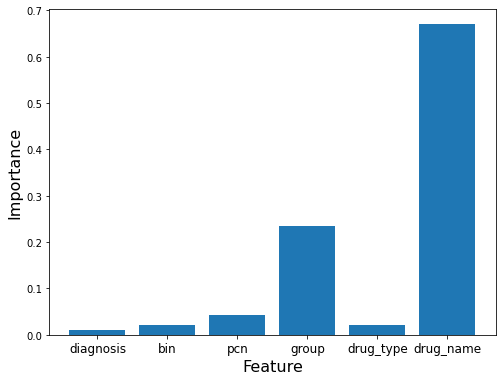

In [17]:
# plot feature importance
plt.figure(figsize=(8,6))
plt.bar(reg_acc.feature_names_in_, reg_acc.feature_importances_)
plt.xticks(fontsize=12)
plt.ylabel("Importance", fontsize=16)
plt.xlabel("Feature", fontsize=16)

plt.show()

We can see that the drug name is most important for predicting co-pay, followed by the patient's insurance information. 

#### Model performance

How does our model perform on the test dataset?

In [18]:
# Make sure the variables are categories, not objects in the test dataset
acc_test["diagnosis"] = acc_test["diagnosis"].astype("category")
acc_test["drug_type"] = acc_test["drug_type"].astype("category")
acc_test["drug_name"] = acc_test["drug_name"].astype("category")
acc_test["bin"] = acc_test["bin"].astype("category")
acc_test["pcn"] = acc_test["pcn"].astype("category")
acc_test["group"] = acc_test["group"].astype("category")

In [19]:
y_pred_baseline = acc_test['patient_pay'].mean()*np.ones(len(acc_test))

y_pred = reg_acc.predict(acc_test[['diagnosis', 'bin', 'pcn', 'group', 'drug_type', 'drug_name']])

#Mean absolute error
mae_baseline = mean_absolute_error(acc_test['patient_pay'], y_pred_baseline)
mae_reg = mean_absolute_error(acc_test['patient_pay'],y_pred)

print("Mean patient pay:", round(acc_test['patient_pay'].mean(), 2))
print("Baseline mean absolute error:", round(mae_baseline, 2))
print("Model mean absolute error:", round(mae_reg, 2))

Mean patient pay 26.1
Baseline mean absolute error: 21.8
Model mean absolute error: 1.17


Our model performs well and predicts a patient's co-pay correctly to within a few dollars. This would help patients to be informed and know whether they will be able to afford the medication that their provider wants to prescribe. 